TODO:
    Try again to fix the series issue in appellation. Remove the first empty character
    Remove price outliers using IQR or zscores. 

In [318]:
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine, insert
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

In [319]:
df = pd.read_csv('wine_scraped_dataset.csv', index_col=0)

## Assess 

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23822 entries, 0 to 23821
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  23822 non-null  object 
 1   price         23822 non-null  object 
 2   varietal      23822 non-null  object 
 3   origin        23819 non-null  object 
 4   rating        23822 non-null  float64
 5   rating_count  23822 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.3+ MB


In [321]:
df.head()

,product_name,price,varietal,origin,rating,rating_count
0,Dom Perignon Vintage with Gift Box 2010,199,Vintage Sparkling Wine,"Champagne, France",4.5,42
1,Veuve Clicquot Yellow Label Brut,59,Non-Vintage Sparkling Wine,"Champagne, France",4.4,1138
2,Duckhorn Napa Valley Cabernet Sauvignon 2017,78,Cabernet Sauvignon,"Napa Valley, California",4.3,62
3,Caymus Special Selection Cabernet Sauvignon 2016,180,Cabernet Sauvignon,"Napa Valley, California",4.6,108
4,Quintessa 2016,199,Cabernet Sauvignon,"Rutherford, Napa Valley, California",4.7,73


### Cleaning 

The following items have been indentified as tidiness/ quality issues:
- 'origin' is missing three values
- separate 'origin' into 'region' and 'appelation'
- Remove non wines from varietals: 'Port' 'Non-Vintage Sparkling Wine' 'Vintage Sparkling Wine'
- Seperate 'year' out of 'product_name' and drop the ones that don't have a year?
- turn remove commas and turn price into int

### 'origin' is missing three values 

In [322]:
df = df[df['origin'].notna()]
# check, if it worked we should see 23819 entries
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23819 entries, 0 to 23821
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  23819 non-null  object 
 1   price         23819 non-null  object 
 2   varietal      23819 non-null  object 
 3   origin        23819 non-null  object 
 4   rating        23819 non-null  float64
 5   rating_count  23819 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 1.3+ MB


###  separate 'origin' into 'region' and 'appelation'

In [323]:
# copy the original dataframe to do the extraction
df_or = df.copy()

# split string from the right at the comma and keep the first two values
df_or = df_or.origin.str.rsplit(',').str[-2:]

# convert to dataframe
df_or = df_or.to_frame()

# split 'origin' string from right into two columns 'appelation' and 'region'
df_or = pd.DataFrame(df.origin.str.rsplit(',', 1).tolist(),
                     columns = ['appellation','region'])
df_or2 = df_or.appellation.str.rsplit(',').str[-1:]
df_or2 = df_or2.to_frame()
df_or2['appellation'] = df_or2['appellation'].astype(str)

# merge the newly constructred df with with 'appelation' and 'region' into two
df_merged = df_or.assign(appellation=df_or2['appellation'])
df = pd.concat([df, df_merged], axis=1)
# and drop the 'origin' columns
df.drop('origin', axis = 1, inplace = True)
df.dropna(inplace = True)

In [324]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22685 entries, 0 to 23818
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  22685 non-null  object 
 1   price         22685 non-null  object 
 2   varietal      22685 non-null  object 
 3   rating        22685 non-null  float64
 4   rating_count  22685 non-null  float64
 5   appellation   22685 non-null  object 
 6   region        22685 non-null  object 
dtypes: float64(2), object(5)
memory usage: 1.4+ MB


In [325]:
df['appellation'].sort_values().unique()

array(['["Valle d\'Aosta"]', "[' Bordeaux']", "[' Burgundy']",
       "[' Central Coast']", "[' Columbia Valley']",
       "[' Friuli-Venezia Giulia']", "[' Loire']", "[' Mendocino']",
       "[' Mendoza']", "[' Napa Valley']", "[' New South Wales']",
       "[' New York']", "[' North Coast']", "[' Piedmont']",
       "[' Prosecco']", "[' Rapel Valley']", "[' Rhone']", "[' Salta']",
       "[' San Antonio Valley (Chile)']", "[' Sierra Foothills']",
       "[' Sonoma County']", "[' South Australia']",
       "[' South of France']", "[' Southwest']",
       "[' Trentino-Alto Adige']", "[' Tuscany']", "[' Veneto']",
       "[' Victoria']", "[' Western Australia']",
       "[' Willamette Valley']", "['Abruzzo']", "['Aconcagua Valley']",
       "['Alentejo']", "['Alsace']", "['Auckland']", "['Basilicata']",
       "['Bierzo']", "['Bordeaux']", "['Burgenland']", "['Burgundy']",
       "['Campania']", "['Canterbury']", "['Carneros']",
       "['Casablanca Valley']", "['Central Coast']", "['Ce

In [326]:
df['appellation'].unique().size

128

In [327]:
df['region'].sort_values().unique()

array([' Argentina', ' Australia', ' Austria', ' California', ' Chile',
       ' France', ' Germany', ' Greece', ' Italy', ' New Zealand',
       ' Oregon', ' Other U.S.', ' Portugal', ' South Africa', ' Spain',
       ' Washington'], dtype=object)

In [328]:
df['region'].unique().size

16

### seperate 'year' out of 'product_name' and drop the ones that don't have a year? 

In [329]:
# this removes the parenthesis and what's between them. made it easier to extract year. 
df['product_name'] = df['product_name'].str.replace(r"\(.*?\)", "")

# the following extract the digit strings from left to right. 
df['year']= df.product_name.str.extract('(\d+)')

# since the year was a the wnd of the product_name string, emove the last 5
# characters at the end of each string to only keep the actual names
df['product_name'] = df['product_name'].str[:-5] #.str[-1:]

# drop any empty rows for quality purposes
df.dropna(inplace = True)

In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22510 entries, 0 to 23818
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  22510 non-null  object 
 1   price         22510 non-null  object 
 2   varietal      22510 non-null  object 
 3   rating        22510 non-null  float64
 4   rating_count  22510 non-null  float64
 5   appellation   22510 non-null  object 
 6   region        22510 non-null  object 
 7   year          22510 non-null  object 
dtypes: float64(2), object(6)
memory usage: 1.5+ MB


### turn the string year into an integer

In [331]:
df['year'] = df['year'].astype(int)

### only keep relevant data with years that aren't obvious outliers 

In [332]:
# drop anything that is older than 1950 - wine is probably not good anymore!
df = df[df['year'] > 1950]  

In [333]:
# drop anything that is youger than 2020 - wine from the future?
df = df[df['year'] <= 2020] 

In [334]:
df['year'].sort_values().unique()

array([1951, 1955, 1959, 1961, 1963, 1964, 1965, 1966, 1967, 1968, 1970,
       1971, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020])

In [335]:
# return row by year to see entry
df.loc[df['year'] ==  1959]

,product_name,price,varietal,rating,rating_count,appellation,region,year
17340,Cantine Antonio Ferrari Solaria Jonica,159,Sangiovese,0.0,0.0,['Central Coast'],California,1959
23729,Chateau Mouton Rothschild,"2,499",Bordeaux Red Blends,0.0,0.0,['Burgundy'],France,1959


In [336]:
df.shape

(21995, 8)

### remove commas and turn price into int 

In [337]:
df['price'] = df['price'].str.replace(',', '')

In [338]:
df['price'].min(), df['price'].max()

('100', '9999')

In [339]:
df['price'] = df['price'].astype(int)

In [340]:
df.dtypes

product_name     object
price             int64
varietal         object
rating          float64
rating_count    float64
appellation      object
region           object
year              int64
dtype: object

### remove price outliers (using IQR) 

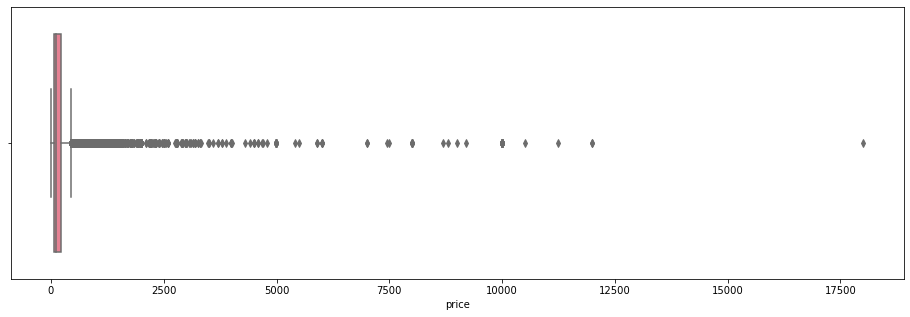

In [341]:
plt.figure(figsize = [16, 5])
sb.boxplot(x=df['price']);

In [342]:
df['price'].describe()

count    21995.000000
mean       230.854922
std        564.229348
min          7.000000
25%         62.000000
50%        109.000000
75%        214.000000
max      17999.000000
Name: price, dtype: float64

In [290]:
from scipy import stats
df['z_score'] = stats.zscore(df['price'])
df['z_score'] = np.abs(df['z_score'])

In [291]:
print(np.where(df['z_score'] > 3))

(array([  143,   170,   246,  1277,  1387,  1405,  1459,  1477,  1489,
        1514,  1578,  1585,  1591,  1602,  1635,  1688,  1704,  1712,
        1729,  1779,  1824,  1851,  1878,  1919,  1937,  1943,  1961,
        1994,  2007,  2018,  2024,  2083,  2085,  2093,  2098,  2103,
        2184,  2255,  2262,  2276,  2305,  2342,  2349,  2781,  2782,
        2800,  2820,  2830,  2871,  2878,  2882,  2889,  2890,  2984,
        3014,  3037,  3191,  3200,  3204,  3211,  3253,  3311,  3335,
        3383,  3391,  3587,  3707,  3831,  3938,  4050,  4264,  4266,
        4303,  4304,  4312,  4314,  4315,  4330,  4360,  4401,  4424,
        4536,  4623,  4791,  4853,  5170,  5180,  5238,  5359,  5483,
        5995,  6027,  6461,  6488,  6605,  6645,  6661,  6693,  6719,
        6748,  6851,  7280,  7343,  7381,  7534,  7761,  7820,  7846,
        7944,  8119,  8125,  8161,  8261,  8552,  8635,  8998,  9254,
        9440,  9672,  9888, 10242, 10843, 10867, 11416, 11618, 12024,
       12317, 12471

### look for zero and non values in the ratings

In [248]:
df['rating'].sort_values().unique()

array([0. , 1.6, 1.9, 2.2, 2.4, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3,
       3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6,
       4.7, 4.8, 4.9, 5. ])

In [220]:
df.groupby('rating').size()

rating
0    17884
1        2
2       12
3      789
4     3118
5      190
dtype: int64

In [249]:
#turn rating_count from float to int
df['rating_count'] = df['rating_count'].astype(int)

In [250]:
df['rating_count'].sort_values().unique()

array([  0,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,
        17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  92,  93,  94,  95,
        97,  99, 100, 101, 102, 103, 105, 106, 107, 108, 109, 110, 112,
       113, 114, 115, 116, 118, 119, 122, 123, 125, 127, 128, 129, 130,
       131, 132, 136, 137, 138, 139, 140, 143, 144, 146, 147, 148, 149,
       150, 151, 152, 156, 157, 158, 160, 164, 166, 168, 169, 172, 174,
       176, 177, 180, 183, 184, 185, 188, 196, 199, 200, 202, 203, 206,
       208, 211, 213, 216, 224, 227, 231, 235, 238, 243, 244, 247, 248,
       251, 257, 263, 267, 271, 276, 278, 281, 283, 292, 294, 29

## Dataframes

### Master  

In [154]:
df.shape

(22010, 8)

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22010 entries, 0 to 23818
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  22010 non-null  object 
 1   price         22010 non-null  int64  
 2   varietal      22010 non-null  object 
 3   rating        22010 non-null  float64
 4   rating_count  22010 non-null  float64
 5   appellation   22010 non-null  object 
 6   region        22010 non-null  object 
 7   year          22010 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 1.5+ MB


In [156]:
df.head()

,product_name,price,varietal,rating,rating_count,appellation,region,year
0,Dom Perignon Vintage with Gift Box,199,Vintage Sparkling Wine,4.5,42.0,['Champagne'],France,2010
2,Duckhorn Napa Valley Cabernet Sauvignon,78,Cabernet Sauvignon,4.3,62.0,['Napa Valley'],California,2017
3,Caymus Special Selection Cabernet Sauvignon,180,Cabernet Sauvignon,4.6,108.0,['Napa Valley'],California,2016
4,Quintessa,199,Cabernet Sauvignon,4.7,73.0,[' Napa Valley'],California,2016
5,Joseph Phelps Insignia,300,Bordeaux Red Blends,4.6,81.0,['Napa Valley'],California,2016


In [157]:
df.to_csv('wine_master_dataset.csv')

###  Wines with Ratings 

In [158]:
df_ratings_only = df.copy()

In [159]:
df_ratings_only = df_ratings_only[df_ratings_only['rating_count'] > 0]  

In [160]:
df_ratings_only.shape

(4112, 8)

In [161]:
df_ratings_only.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4112 entries, 0 to 23786
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  4112 non-null   object 
 1   price         4112 non-null   int64  
 2   varietal      4112 non-null   object 
 3   rating        4112 non-null   float64
 4   rating_count  4112 non-null   float64
 5   appellation   4112 non-null   object 
 6   region        4112 non-null   object 
 7   year          4112 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 289.1+ KB


In [162]:
df_ratings_only.head()

,product_name,price,varietal,rating,rating_count,appellation,region,year
0,Dom Perignon Vintage with Gift Box,199,Vintage Sparkling Wine,4.5,42.0,['Champagne'],France,2010
2,Duckhorn Napa Valley Cabernet Sauvignon,78,Cabernet Sauvignon,4.3,62.0,['Napa Valley'],California,2017
3,Caymus Special Selection Cabernet Sauvignon,180,Cabernet Sauvignon,4.6,108.0,['Napa Valley'],California,2016
4,Quintessa,199,Cabernet Sauvignon,4.7,73.0,[' Napa Valley'],California,2016
5,Joseph Phelps Insignia,300,Bordeaux Red Blends,4.6,81.0,['Napa Valley'],California,2016


In [174]:
df_ratings_only.shape

(4112, 8)

### Wines with Bonafide Varietals

In [163]:
df['varietal'].unique().size

84

In [164]:
# copy original dataframe for manipulation
df_varietals = df.copy()

# create the list or non-varietals - identified from 88 unique varietals
non_varietals = ['Port', 'Non-Vintage Sparkling Wine', 'Vintage Sparkling Wine']

# Delete these row indexes from dataFrame that have the non-variatals in them
df_varietals = df_varietals[~df_varietals['varietal'].isin(non_varietals)]

In [165]:
# this is the df with the non-wine varietals
df_varietals['varietal'].sort_values().unique()

array(['Agiorgitiko', 'Aglianico', 'Albarino', 'Alicante Bouschet',
       'Arneis', 'Assyrtiko', 'Baga', 'Barbera', 'Blaufrankisch', 'Bobal',
       'Bordeaux Red Blends', 'Bordeaux White Blends', 'Cabernet Franc',
       'Cabernet Sauvignon', 'Carignan', 'Carmenere', 'Chardonnay',
       'Chenin Blanc', 'Corvina', 'Dolcetto', 'Fiano', 'Friulano',
       'Fruit Wine', 'Furmint', 'Gamay', 'Garganega', 'Gewurztraminer',
       'Godello', 'Greco', 'Grenache', 'Grenache Blanc',
       'Gruner Veltliner', 'Lagrein', 'Madeira', 'Malbec', 'Marsanne',
       'Melon de Bourgogne', 'Mencia', 'Merlot', 'Montepulciano',
       'Mourvedre', 'Muscat', 'Nebbiolo', 'Nerello Mascalese',
       "Nero d'Avola", 'Other Dessert', 'Other Red Blends',
       'Other Red Wine', 'Other White Blends', 'Other White Wine',
       'Petit Verdot', 'Petite Sirah', 'Pinot Blanc', 'Pinot Gris/Grigio',
       'Pinot Noir', 'Pinotage', 'Red Sparkling Wine', 'Rhone Red Blends',
       'Rhone White Blends', 'Riesling', 'R

In [166]:
df_varietals.shape

(21385, 8)

In [167]:
df_varietals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21385 entries, 2 to 23818
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  21385 non-null  object 
 1   price         21385 non-null  int64  
 2   varietal      21385 non-null  object 
 3   rating        21385 non-null  float64
 4   rating_count  21385 non-null  float64
 5   appellation   21385 non-null  object 
 6   region        21385 non-null  object 
 7   year          21385 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 1.5+ MB


In [168]:
df_varietals.head()

,product_name,price,varietal,rating,rating_count,appellation,region,year
2,Duckhorn Napa Valley Cabernet Sauvignon,78,Cabernet Sauvignon,4.3,62.0,['Napa Valley'],California,2017
3,Caymus Special Selection Cabernet Sauvignon,180,Cabernet Sauvignon,4.6,108.0,['Napa Valley'],California,2016
4,Quintessa,199,Cabernet Sauvignon,4.7,73.0,[' Napa Valley'],California,2016
5,Joseph Phelps Insignia,300,Bordeaux Red Blends,4.6,81.0,['Napa Valley'],California,2016
6,Opus One,364,Bordeaux Red Blends,4.2,8.0,[' Napa Valley'],California,2017


# Store in SQL Database 

In [177]:
# Create SQLAlchemy Engine and empty bestofrt database
# bestofrt.db will not show up in the Jupyter Notebook dashboard yet
engine = create_engine('sqlite:///winewebscraping.db')

In [178]:
# Store cleaned master DataFrame ('df') in a table called master in marswind.db
# marswind.db will be visible now in the Jupyter Notebook dashboard
df.to_sql('master', engine, index=False)
df_ratings_only.to_sql('ratings', engine, index=False)
df_varietals.to_sql('varietals', engine, index=False)

In [179]:
df_db = pd.read_sql('SELECT * FROM varietals', engine)

In [180]:
df_db.head(3)

,product_name,price,varietal,rating,rating_count,appellation,region,year
0,Duckhorn Napa Valley Cabernet Sauvignon,78,Cabernet Sauvignon,4.3,62.0,['Napa Valley'],California,2017
1,Caymus Special Selection Cabernet Sauvignon,180,Cabernet Sauvignon,4.6,108.0,['Napa Valley'],California,2016
2,Quintessa,199,Cabernet Sauvignon,4.7,73.0,[' Napa Valley'],California,2016
